# Random Forest to predict house price

## Programming Language: R

- Remove ID column because ID isn't a effectable predictor.

In [1]:
H = read.csv(url("http://fs2.american.edu/~baron/627/R/HOME_SALES.csv"))
H$ID <- NULL
head(H)

,SALES_PRICE,FINISHED_AREA,BEDROOMS,BATHROOMS,GARAGE_SIZE,YEAR_BUILT,STYLE,LOT_SIZE,AIR_CONDITIONER,POOL,QUALITY,HIGHWAY
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,360000,3032,4,4,2,1972,1,22221,YES,NO,MEDIUM,NO
2,340000,2058,4,2,2,1976,1,22912,YES,NO,MEDIUM,NO
3,250000,1780,4,3,2,1980,1,21345,YES,NO,MEDIUM,NO
4,205500,1638,4,2,2,1963,1,17342,YES,NO,MEDIUM,NO
5,275500,2196,4,3,2,1968,7,21786,YES,NO,MEDIUM,NO
6,248000,1966,4,3,5,1972,1,18902,YES,YES,MEDIUM,NO


# Split data. 80% for train/ 20% for test.

In [2]:
set.seed(1)
n = nrow(H)
z = sample(n, n*0.8) # 0.8 for train, 0.2 for test

In [3]:
library(randomForest)
train_RF = randomForest(SALES_PRICE~., data= H[z,])
train_RF

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.




Call:
 randomForest(formula = SALES_PRICE ~ ., data = H[z, ]) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 3265195110
                    % Var explained: 82.79

- Why model choose 3 variables at each split?
- Rule of thumb: usually m ~= root(p)

In [4]:
p = ncol(H)-1 # deduct response
p
sqrt(p) # No. of variables tried at each split: 3

[1] 11

[1] 3.316625

# Test model
- RMSE: 55914.489

In [5]:
yhat = predict(train_RF, newdata= H[-z,])

sqrt(mean((yhat - H[-z,]$SALES_PRICE)^2)) # RMSE

[1] 55914.49

# Tune and test model again
## Try other variables and trees

- Try all variables (11).
- RMSE(57911.54) is higher than 3 variables.

In [6]:
train_RF = randomForest(SALES_PRICE~., data= H[z,],  mtry= 11) # 3 -> 11 variables
train_RF

yhat = predict(train_RF, newdata= H[-z,])
sqrt(mean((yhat - H[-z,]$SALES_PRICE)^2)) # RMSE: 3 is better than 11


Call:
 randomForest(formula = SALES_PRICE ~ ., data = H[z, ], mtry = 11) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 11

          Mean of squared residuals: 3379074480
                    % Var explained: 82.19

[1] 57911.54

- Try different trees.
- RMSE(58345.46) is getting higher.

In [7]:
train_RF = randomForest(SALES_PRICE~. , data= H[z, ], mtry= 11, ntree= 100) # 3 -> 11 variables, 500 -> 100 trees
yhat = predict(train_RF, newdata= H[-z, ])
sqrt(mean((yhat - H[-z, ]$SALES_PRICE)^2)) # RMSE is going up

[1] 58345.46

# Find the best trees and variables

In [8]:
set.seed(1)
n = nrow(H)
z = sample(n, n*0.8)

RMSEP = rep(0,p) # p = 11 predictors. try every predictors to find the best random forest
optimaltrees = rep(0,p)

for(k in 1:p){
  train_RF = randomForest(SALES_PRICE~., data= H[z,], mtry= k)
  optimaltrees[k] = which.min(train_RF$mse) # In each variables selection, number with lowest mse = optimal trees.
  
  train_RF = randomForest(SALES_PRICE~., data= H[z,], mtry= k, ntree= optimaltrees[k])
  yhat = predict(train_RF, newdata = H[-z,])
  RMSEP[k] = sqrt(mean((yhat- H$SALES_PRICE[-z])^2))
  #plot(train_RF$mse)
}

In [9]:
which.min(RMSEP)

[1] 4

In [12]:
RMSEP[4]
optimaltrees[4]
optimaltrees

[1] 53939.18

[1] 288

[1]  25  60 498 288 467  63  88 106  31 323 498

# Fit best random forest trees (mtry= 4, ntree= 288)

- After tuning, best RF model's testing RMSE is 57549.54

In [15]:
best_RF = randomForest(SALES_PRICE~., data= H[z, ], mtry= 4, ntree= 288) 
best_RF


Call:
 randomForest(formula = SALES_PRICE ~ ., data = H[z, ], mtry = 4,      ntree = 288) 
               Type of random forest: regression
                     Number of trees: 288
No. of variables tried at each split: 4

          Mean of squared residuals: 3361704544
                    % Var explained: 82.29

In [16]:
sqrt(3311949216) # RMSE

[1] 57549.54

,IncNodePurity
FINISHED_AREA,2.417749e+12
BEDROOMS,1.958734e+11
BATHROOMS,9.414076e+11
GARAGE_SIZE,4.161065e+11
YEAR_BUILT,8.595292e+11
STYLE,1.609629e+11
LOT_SIZE,3.717404e+11
AIR_CONDITIONER,1.731514e+10
POOL,3.702519e+10
QUALITY,2.309899e+12


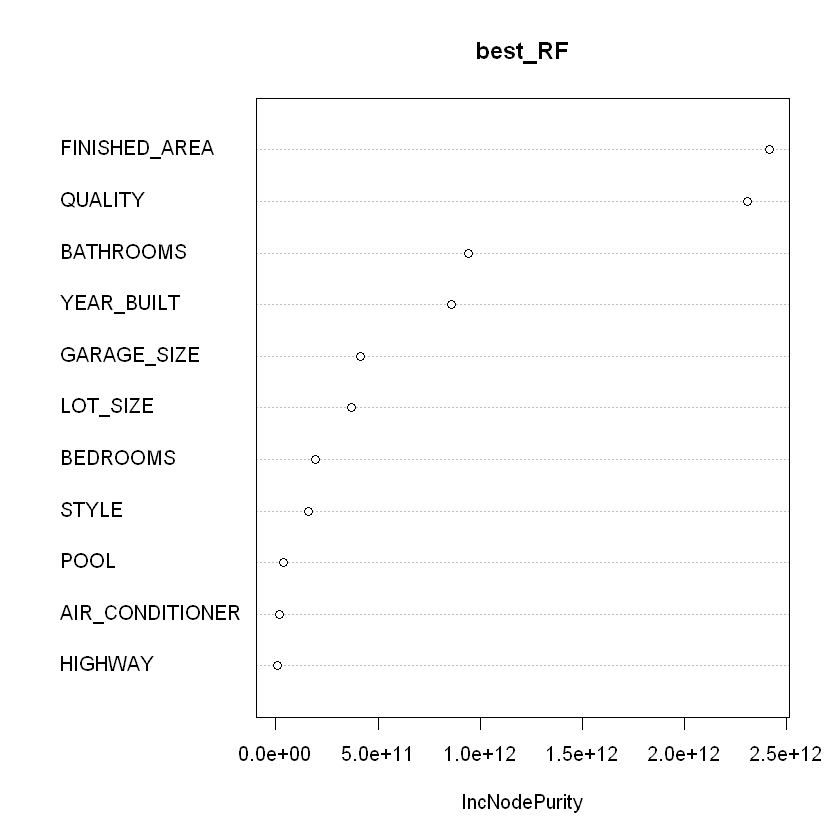

In [17]:
importance(best_RF) 
varImpPlot(best_RF)